<a href="https://colab.research.google.com/github/Echo9k/CoS-Crime_GTA-San-Francisco/blob/master/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [0]:
# Code to read csv file into Colaboratory:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True) ## Defining the color map

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive/')
import glob

import os
os.chdir("/content/drive/My Drive/info/ConcentradoClientes")
print("Working directory:\n", os.getcwd())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Working directory:
 /content/drive/My Drive/info/ConcentradoClientes


## Importing data

In [0]:
%cd /content/drive/My Drive/info/ConcentradoClientes
%ls

/content
cc_2014.xlsx  cc_2017.xlsx        CustomerData.csv     RPV_score.csv
cc_2015.xlsx  cc_2018.xlsx        ReporteLealtad.xlsx
cc_2016.xlsx  cc_oct18-sep19.csv  RFC_labels.csv


In [0]:
def append_data(fileNames,
                usecols=None):
  """ Reads a list of file names/paths, then
      appends it in a single pandas.DataFrame; 
  fileNames takes the file path; 
  usecols takes the list of columns to use (list of int / str)"""
  data = pd.DataFrame()
  for file in fileNames:
    df = pd.read_excel(file, sheet_name='Hoja1',
                      header=1, 
                      usecols=usecols,
                      date_parser=['FECHA', 'FECHA2', 'FECHA3'],
                      ignore_index=True,
                      sort=True)
    
    df.dropna(0,'any', 5, None, True)
    
    data = pd.concat([data, df], ignore_index=True)
    
  print("Successful DataFrame creation!")
  print("shape:", data.shape)
  return data

In [0]:
# Read the data from previous years
fileNames = glob.glob('*'+'cc_20'+'*.xlsx')   # get the file names

# read files, store data appended: previous_years_data
previous_years = append_data(fileNames,
                             list(range(0,44)))

Successful DataFrame creation!
shape: (1201961, 44)


In [0]:
# Include the data from 2019
## Read the data from 2019, use range to drop the column 'CANCELADO'
data_2019 = pd.read_csv("cc_oct18-sep19.csv",
                        usecols=list(range(0,44)),
                        parse_dates=['FECHA', 'FECHA2', 'FECHA3'],
                        low_memory=False)

data_2019.dropna(0,'any', 6, None, True)

## Remove the spaces from the colum names
data_2019.columns = data_2019.columns.str.replace(' ','')
previous_years.columns = previous_years.columns.str.replace(' ','')

## Select the rows from 2019
data_2019 = data_2019[data_2019['FECHA3'] >= '01/01/2019']

In [0]:
## Concatenate all the data: raw_data
raw_data = pd.concat([previous_years, data_2019],
                     sort=True,
                     ignore_index=True)

# Inspecting data

## Initial inspection

In [0]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    df.columns.name = 'missing values'
    df.index.name = 'features to fix'
    return df[df.Percent>0]

In [0]:
# # Select the columns with more than 20% of missing values
cols_with_na = missing_data(raw_data)
raw_data.drop(cols_with_na[cols_with_na.Percent > 15].index,
             axis=1,
             inplace=True)
missing_data(raw_data)

missing values,Total,Percent
features to fix,,
MARCA,721,0.057232
MODELO,469,0.037229
MUNICIPIO,443,0.035165
ESTADO,356,0.028259
COLONIA,180,0.014288
TIPOTELEFONO,106,0.008414
CP,43,0.003413
EDAD,18,0.001429
DIRECCIÓN,16,0.001270


## Selecting columns

In [0]:
# Drop sensitive information
sensitive_cols = ['NOMBRE', 'PATERNO', 'MATERNO', 'DIRECCIÓN',
                  'COLONIA', 'TELÉFONO', 'TIPOTELEFONO']
raw_data.drop(sensitive_cols, axis=1, inplace=True)

raw_data.drop(['MODELO'], axis=1,
             inplace=True)  # We wont use this

In [0]:
# cast that observation as int present in #ARTUCULOS
# identify and deleate the row with '  12:00:00 a. m.'
bool_list = raw_data['#ARTUCULOS'] == '  12:00:00 a. m.'
idx_to_drop = raw_data[bool_list].index
raw_data.drop(idx_to_drop,
             inplace=True)

raw_data['#ARTUCULOS'][raw_data['#ARTUCULOS'] == '  12:00:00 a. m.'].index

# some rows have an ':' symbol which we want to remove
raw_data['#ARTUCULOS'] = raw_data['#ARTUCULOS'].apply(
                                  lambda x: float(x.replace(':', ''))
                                  if type(x) == str else x)

# Data cleaning

## Set up

## Inputation
Some rows contain missing information in the form of negative ones and nans.
To fix this we are going to use two separate sklearn imputers.

*   First for the NA values of the MONTO column
*   Then for the -1 values in the selected columns



## Imputer

In [0]:
raw_data.drop(columns=['PRENDADOS', 'PRESTAMO'], inplace=True)

In [0]:
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [0]:
# Select non numeric columns
obj_cols = (raw_data.dtypes == 'object').index
# checks if the col contain the '$'
cash_cols = raw_data[obj_cols].columns[raw_data.iloc[-1].str.contains('\$') == True]

In [0]:
raw_data[cash_cols] = raw_data[cash_cols].apply(lambda x: x.str.replace('$', ''))
raw_data[cash_cols] = raw_data[cash_cols].apply(lambda x: x.str.replace(' ', ''))
raw_data[cash_cols] = raw_data[cash_cols].apply(lambda x: x.str.replace(',', ''))
raw_data[cash_cols] = raw_data[cash_cols].apply(lambda x: x.str.replace('-', ''))

raw_data.replace('', np.nan, inplace=True)
raw_data.replace(-1, np.nan, inplace=True)

raw_data['PRESTAMO'] = raw_data['PRESTAMO'].apply(
                                  lambda x: float(x.replace(':', ''))
                                  if type(x) == str else x)

# raw_data[cash_cols] = raw_data[cash_cols].apply(lambda x: x.astype(float))

In [0]:
raw_data.dropna(0, 'any', 3, None, True)

cols_with_na = missing_data(raw_data)
raw_data.drop(cols_with_na[cols_with_na.Percent > 50].index,
             axis=1,
             inplace=True)
missing_data(raw_data)

missing values,Total,Percent
features to fix,,
MARCA,721,0.057232
MUNICIPIO,443,0.035165
ESTADO,356,0.028259
EDAD,81,0.006430
CP,43,0.003413
GENERO,10,0.000794


In [0]:
# list numerical columns only
is_number = np.vectorize(lambda x: np.issubdtype(x, np.number))
numeric_cols_bool = is_number(raw_data.dtypes)
numeric_cols = raw_data.columns[numeric_cols_bool]
numeric_cols = list(set(numeric_cols) - set(['CP','CALIFICACIONORIGINAL', 'CALIFICACIONFINAL']))

In [0]:
raw_data[['CALIFICACIONORIGINAL', 'CALIFICACIONFINAL']].apply(lambda x: x.replace(np.nan, 'BRONCE'))

imp = IterativeImputer()
raw_data[numeric_cols] = imp.fit_transform(raw_data[numeric_cols])

imp = IterativeImputer(missing_values=-1)
raw_data[numeric_cols] = imp.fit_transform(raw_data[numeric_cols])

### Age correction

In [0]:
# Age correction using RFC as reference
# Select the RFC (index) of the customers with a suspicious age
wrong_age = raw_data[(raw_data.EDAD<18) | (raw_data.EDAD>100)].index
RFC_to_ck = raw_data.loc[wrong_age].index

# Extract the birthday from the RFC
raw_data['bday'] = [i[4:10] for i in raw_data.RFC]
# raw_data['bday'] = pd.to_datetime(raw_data['bday'], format='%y%m%d')

# Extract bday, get the age and replace the original.
bday = raw_data['bday'][RFC_to_ck]
time_difference = pd.Timestamp.now() - pd.to_datetime(bday,
                                                      format='%y%m%d')
time_difference = time_difference.astype('timedelta64[D]')  # Extract the days
years = (time_difference / 365).astype(int)  # convert days to years

raw_data.EDAD[wrong_age] = years

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [0]:
np.nan_to_num(raw_data['EDAD'], False, 0, 0, 0)

cols_with_negs = [-1 in raw_data[name].values for name in raw_data.columns]
colNames_negs = raw_data.columns[cols_with_negs] # gets colum names

imp = SimpleImputer(missing_values=-1,
                    strategy='mean')

a = imp.fit_transform(raw_data[colNames_negs])
raw_data[colNames_negs] = a.astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# Seting RFC as the index
raw_data.sort_values('FECHA3',
                    inplace=True)       # Sort FECHA3 (last transaction)

raw_data.drop_duplicates('RFC',
                        'last', True)   # last transaction per client

# replace RFC with labels
le = preprocessing.LabelEncoder()
RFC_labeled = le.fit_transform(raw_data['RFC'])
RFC_labels = pd.DataFrame({'rfc':raw_data['RFC']}).set_index(RFC_labeled)
RFC_labels.to_csv('RFC_labels.csv')     # Export labels-RFC as CSV

raw_data.set_index(RFC_labeled,
                  inplace=True)        # Set the index

In [0]:
# caps min age to 18 y/o
raw_data['EDAD'] = raw_data['EDAD'].where(raw_data['EDAD'] >= 18, 18)
raw_data['EDAD'] = raw_data['EDAD'].where(raw_data['EDAD'] <= 100, 820)

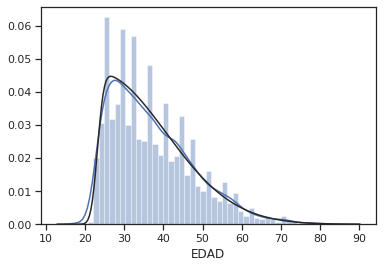

In [0]:
# from scipy import stats
sns.distplot(raw_data.EDAD[:10000], fit=st.skewnorm)

# Feature engeneering

This is is were we export our data cleaned and corrected. To use it later anywhere. Also it will be a checkpoint for us.

In [0]:
# Export the raw_data as: 
raw_data.to_csv('CustomerData.csv')

### New features

In [0]:
# Has retruned in August or later?
raw_data['last3m'] = raw_data.FECHA3>'2019-06-30'

In [0]:
# Counts the repetitions of each RFC
freq = raw_data.RFC.value_counts()
freq.name = 'frequency'

# obteins the tenure for each RFC
tenure = raw_data.groupby(['RFC'])['FECHA3'].min()
tenure.name = 'tenure'

# Include the frequency column at the correct RFC
raw_data = raw_data.join(freq,
                       on='RFC')  # includes the frecuency column

raw_data = raw_data.join(tenure,
                       on='RFC')  # includes the tenure column

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

a = imp.fit_transform(raw_data[['CALIFICACIONFINAL','CALIFICACIONORIGINAL']])
raw_data[['CALIFICACIONFINAL','CALIFICACIONORIGINAL']] = a

In [0]:
# Compute the change of lending score
score_cols = ['CALIFICACIONFINAL', 'CALIFICACIONORIGINAL']
raw_data[score_cols] = raw_data[score_cols].replace({'DIAMANTE': 3,
                                                   'ORO': 2,
                                                   'PLATA': 1,
                                                   'BRONCE': 0})

raw_data['CALIFICACIONORIGINAL'] = raw_data['CALIFICACIONORIGINAL'].astype(int)
raw_data['CALIFICACIONFINAL'] = raw_data['CALIFICACIONFINAL'].astype(int)

raw_data['ScoreChange'] = raw_data.CALIFICACIONFINAL - raw_data.CALIFICACIONORIGINAL

## Label columns

In [0]:
obj_cols = raw_data.columns[(raw_data.dtypes == 'object')]
labeled = pd.DataFrame(index=raw_data.index)
for col in obj_cols:
  le = preprocessing.LabelEncoder()
  labeled[col] = le.fit_transform(raw_data[col])

In [0]:
pd.concat([labeled, raw_data[numeric_cols]], axis=1)

# PreProcesing

## Distribution analisis

In [0]:
from scipy.stats import skew
from scipy.stats import skewtest
from scipy.stats import kurtosis

# Measure skewness and kurtosis
def stats_data(df, cols):
  cc_stats = pd.DataFrame()
  cc_stats['skew'] = [skew(df[i]) for i in df[cols]]
  cc_stats['kurtosis'] = [kurtosis(df[i]) for i in df[cols]]
  cc_stats['skewtest'] = [skewtest(df[i])[0] for i in df[cols]]
  # cc_stats['p_value'] = [skewtest(df[i])[1] for i in df[cols]]
  cc_stats.index = cols
  return cc_stats.sort_values('skew', 0, False)

In [0]:
# Find the inclinations of each numerical column
stats_data(raw_data, numeric_cols).head()

## Transformations

In [0]:
# Transformations
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(
    output_distribution='normal', random_state=1)
Q_trans = transformer.fit_transform(raw_data[numeric_cols])

cc_qartileTransform = pd.DataFrame(Q_trans, raw_data.index, columns=numeric_cols)
# cc_qartileTransform.describe()
stats_data(cc_qartileTransform, numeric_cols).head(3).round(2)

In [0]:
# Transformations
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer()
P_trans = transformer.fit_transform(raw_data[numeric_cols])

cc_powTransform = pd.DataFrame(Q_trans, raw_data.index, columns=numeric_cols)
# cc_powTransform.describe()
stats_data(cc_powTransform, numeric_cols).head(3).round(2)

Comparing the resoult for the column #REFRENDOS

In [0]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1); plt.title('Quartile Transformation')
sns.distplot(Q_trans[0])

plt.subplot(1,2,2); plt.title('Power Transformation')
sns.distplot(P_trans[0])

## Scaling

In [0]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler

In [0]:
transformer = RobustScaler()

cc_robustScale = pd.DataFrame(transformer.fit_transform(cc_powTransform),
                              raw_data.index, columns=numeric_cols)

In [0]:
# Compare their graphs
plt.figure(figsize=(16,5))
plt.subplots_adjust(hspace=0.3)

# afterRobustScale
rs_ref = cc_robustScale['#REFRENDOS']
s = ("skeness {skewness}:  \nkurtosis: {kurtosis} \nmean:   {mean} \nstdev:    {stdev}").\
                                format(skewness = skew(rs_ref.dropna()),
                                       kurtosis = kurtosis(rs_ref.dropna()),
                                       mean = np.mean(rs_ref.dropna()),
                                       stdev = np.std(rs_ref.dropna()))
plt.subplot(1,2,2); plt.title('robustScale')
plt.text(0, 4, s, fontsize=12)
sns.distplot(rs_ref.dropna())


In [0]:
fig = plt.figure(figsize=(20, 60))
for i in range(len(cc_powTransform.columns)):
  plt.subplot(len(cc_powTransform.columns), 3, (i+1))
  plt.subplots_adjust(hspace=0.5)
  # plt.title(numeric_cols[i])
  sns.distplot(cc_powTransform[cc_powTransform.columns[i]], hist=True)

# RFMT analisis

In [0]:
# Define a function to add a label according to the client score
def RFMT_Level(scores):
  intervals = pd.qcut(raw_data['RFM_Level'], q=4).sort_values().unique()
  levels = []
  for score in scores:
    if score in intervals[0]:
        levels.append('low')
    elif score in intervals[1]:
        levels.append('Mid_L')
    elif score in intervals[2]:
        levels.append('Mid_H')
    else:
        levels.append('High')
  return levels

In [0]:
vm_values = pd.qcut(raw_data['MONTO_ANUAL'], q=4, labels=range(1,5))
pct_values = pd.cut(raw_data['PORCENTAJE'], 4, labels=range(1,5))
r_values = pd.qcut(raw_data['FECHA3'], q=4, labels=range(1,5))
t_values = pd.qcut(raw_data['tenure'], q=4, labels=range(4,0,-1))

In [0]:
quartiles = pd.DataFrame({'RecentVisitor':raw_data.last3m,
                          'DateLastVisit':raw_data.FECHA3,
                          'Tenure':raw_data.tenure})

quartiles = quartiles.assign(
                V = vm_values,
                P = pct_values,
                R = r_values,
                T = t_values)
quartiles[['V','P', 'R', 'T']]  = quartiles[['V','P', 'R', 'T']].astype(int)
quartiles['RFMT_Score'] = quartiles[['R','P','V', 'T']].sum(axis=1)

quartiles['label'] = RFMT_Level(quartiles['RFMT_Score'])

In [0]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = quartiles.groupby(['label']).agg({
    'R': 'mean',
    'P': 'mean',
    'V': 'mean',
    'T': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

In [0]:
quartiles.head()

In [0]:
# Snake plot
## using normalized data
sk_melt = pd.melt(quartiles.reset_index(),
        id_vars = ['index', 'RFMT_Score'],
        value_vars = ['R', 'P', 'V', 'T'],
        var_name = 'Attribute',
        value_name = 'Value')

plt.figure(figsize=(15,9)); plt.title('4k | Snake plot')
sns.lineplot(data = sk_melt,
             x = 'Attribute', y = 'Value',
             hue='RFMT_Score',
             sort=False)
plt.show()

In [0]:
sns.distplot(quartiles.RFMT_Score, kde=False)

# Clustering

## Dimensionality Reduction

### **PCA** Principal Component Analisis

## KMeans Clustering


## Correlations

In [0]:
def corr_sqr(df, target, var):
  fig = plt.figure(figsize=(17,25))
  cmap = sns.diverging_palette(220, 10, as_cmap=True) ## Defining the color map

  corrmat = df.corr()
  cols = abs(corrmat).nlargest(var, target)[target].index

  # correlation matrix
  plt.figure(); plt.title('Correlation matrix (num_cols)')
  cm = np.corrcoef(raw_data[cols].values.T)
  sns.set(font_scale=1.1)
  hm = sns.heatmap(cm, cbar=True, cmap=cmap, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
  plt.show()

In [0]:
# corr_sqr(cc_robustScale, 'Refrendos', 9)

## Clustering
Lets start with a simple cluster witouth feature engeneering

In [0]:
from sklearn.cluster import KMeans

### Choosing the number of clusters

In [0]:
sse = {}
for k in range(1,20):
  km = KMeans(n_clusters=k, random_state=1)
  km.fit(cc_robustScale)
  sse[k] = km.inertia_

In [0]:
plt.figure(figsize=(7,3))
plt.title("Elbow plot of inertia for diferent number of clusters")
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Comparing diferent k values


#### 4 Neighbors
As suggested by the elbow method, let's start setting k=4.

In [0]:
cc_robustScale.describe()

In [0]:
# 4 neighbors | The recomendation
km = KMeans(n_clusters=4, random_state=1)
km.fit(cc_robustScale)
cluster_labels = km.labels_

# Table with original data
cc_rfm_k4 = raw_data.assign(Cluster = cluster_labels,
                           Reciente = quartiles.R)

cc_rfm_k4.groupby('Cluster').agg({
    'Reciente': 'mean',
    'PORCENTAJE' : 'mean',
    'MONTO_ANUAL' : ['mean', 'count']
}).round(2)

<h5>Snake plot</h5>

In [0]:
# Snake plot
## using normalized data
sk_data = cc_robustScale.assign(Cluster = cluster_labels,
                                R = quartiles.R - np.mean(quartiles.R))

sk_data.PORCENTAJE = (cc_robustScale.PORCENTAJE)
sk_melt = pd.melt(sk_data.reset_index(),
        id_vars = ['RFC', 'Cluster'],
        value_vars = ['R', 'PORCENTAJE', 'MONTO_ANUAL'],
        var_name = 'Attribute',
        value_name = 'Value')

plt.figure(figsize=(15,9))
plt.title('4k | Snake plot')
sns.lineplot(data = sk_melt,
             x = 'Attribute', y = 'Value',
             hue='Cluster', sort=False,)
plt.show()

In [0]:
# Calculate average RFM values for each cluster
cluster_avg = cc_rfm_k4.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = cc_rfm_k4.mean(axis=0)

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# heat map of relative importance for each 
plt.figure(figsize=(10, 8))
sns.heatmap(relative_imp.T, annot=True, fmt='.2f')
plt.show()

#### 3 Neighnors

In [0]:
# 3 neighbors | The recomendation
km = KMeans(n_clusters=3, random_state=1)
km.fit(cc_robustScale)
cluster_labels = km.labels_

cc_rfm_k3 = raw_data.assign(Cluster = cluster_labels,
                           R = quartiles.R)

cc_rfm_k3.groupby('Cluster').agg({
    'R': 'mean',
    'PORCENTAJE' : 'mean',
    'MONTO_ANUAL' : ['mean', 'count']
}).round(0)

In [0]:
# Snake plot
sk_data = cc_robustScale.assign(Cluster = cluster_labels,
                                R = 3 * (quartiles.R - np.mean(quartiles.R)))

sk_data.PORCENTAJE = (1.2*cc_robustScale.PORCENTAJE)
sk_melt = pd.melt(sk_data.reset_index(),
        id_vars = ['RFC', 'Cluster'],
        value_vars = ['R', 'PORCENTAJE', 'MONTO_ANUAL'],
        var_name = 'Attribute',
        value_name = 'Value')

plt.figure(figsize=(15,9))
plt.title('3k | Snake plot')
sns.lineplot(data = sk_melt,
             x = 'Attribute', y = 'Value',
             hue='Cluster', sort=False)
plt.show()

#### 5 Neighbors

In [0]:
# 5 neighbors
km = KMeans(n_clusters=5, random_state=1)
km.fit(cc_robustScale)
cluster_labels = km.labels_

sk_data.PORCENTAJE = (2.5*cc_robustScale.PORCENTAJE)
cc_rfm_k5 = raw_data.assign(Cluster = cluster_labels,
                           R = quartiles.R)

cc_rfm_k5.groupby(['Cluster']).agg({
    'PRESTAMOSLIQUIDADOS': 'mean',
    'PORCENTAJE' : 'mean',
    'MONTO_ANUAL' : ['mean', 'count']
}).round(0)

In [0]:
# Snake plot
sk_data = cc_robustScale.assign(Cluster = cc_rfm_k5.Cluster,
                             R = 3.2 * (quartiles.R - np.mean(quartiles.R)))

sk_melt = pd.melt(sk_data.reset_index(),
        id_vars = ['RFC', 'Cluster'],
        value_vars = ['R', 'PORCENTAJE', 'MONTO_ANUAL'],
        var_name = 'Attribute',
        value_name = 'Value')

plt.figure(figsize=(15,9))
plt.figure(figsize=(15,9))
plt.title('5k | Snake plot')
sns.lineplot(data = sk_melt,
             x = 'Attribute', y = 'Value',
             hue='Cluster', sort=False)
plt.show()

### Fuerther Analisis

In [0]:
cc_rfm_k4.groupby(['Cluster', 'Active']).agg({
    'PRESTAMOSLIQUIDADOS': 'mean',
    'PORCENTAJE' : 'mean',
    'MONTO_ANUAL' : ['mean', 'count']
}).round(0)

#### snake plot

In [0]:
cc_robustScale.describe()

In [0]:
raw_data[score_cols] = raw_data[score_cols].replace({ '3': 'DIAMANTE',
                                                      '2': 'ORO',
                                                      '1': 'PLATA',
                                                      '0': 'BRONCE'})
raw_data.join(cc_rfm_k4.Cluster, how='inner').to_csv("cc_clustered.csv")